# Задача для исследования  

Ты аналитик в компании, которая развивает сервис доставки продуктов.
Команда разработчиков запустила A/B эксперимент, в котором тестирует новую функциональность мобильного приложения - блок на главной странице с историей заказов пользователя.  

Блок дает возможность повторить заказ / добавить товары из этого блока в корзину.
### Группы эксперимента:  
- группа “a” (контрольная) - не видит данного блока  
- групп “b” (тестовая) - видит новый блок с историей заказов         

### Описание доступных данных  
1 - data_ab_groups.csv - данные о группе эксперимента пользователя.  
Поля:  
user_id - идентификатор пользователя,  
ab_group - группа эксперимента  

2 - data_financial.csv - данные о тратах пользователей.  
Поля:  
date - дата захода в приложение,   
user_id - идентификатор пользователя,   
spendings - траты пользователей, руб


## Задачи:  

1 - найти кол-во пользователей, которые попали более чем в одну группу эксперимента  
2 - сформировать таблицу с колонками: айди пользователя, группа эксперимента, траты пользователя.  
Комментарий:  
- пользователей с несколькими группами исключаем из финальной таблицы,  
- траты пользователей должны быть агрегированы за весь период  

3 - Построить boxplot по тратам пользователей в разрезе группы эксперимента.прокомментировать наличие выбросов, обработать выбросы при их наличии.  
4 - Выбрать статистический критерий, подвести итоги по эксперименту (посчитать аплифт в тратах и его статзначимость, дать выводы и рекомендации менеджеру).


https://drive.google.com/file/d/184KUn-TvAd-L-GI5YPZSADsUVlzLAgm6/view?usp=sharing       :  data_financial.csv  

https://drive.google.com/file/d/1x502JsFV3mJVrfX5UpSKkwff8y8cWB7Y/view?usp=drive_link   : data_ab_groups.csv



In [2]:
# @title Импорт библиотек и создание образа Google drive disk
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

In [ ]:
#@title Блок Google Collab

# from google.colab import drive
# drive.mount('/content/gdrive')

# print('Гружу образ гугл диска во временную среду')
# for i in tqdm(range(20)):
#     time.sleep(1)
# print(' ')
# print('Загрузил образ гугл диска во временную среду')
# print(' ')

# ! cp /content/gdrive/MyDrive/1_pet_project/task_Alex_Gavrilov_abtest_python/data_ab_groups.csv /content/data_ab_groups.csv
# ! cp /content/gdrive/MyDrive/1_pet_project/task_Alex_Gavrilov_abtest_python/data_financial.csv /content/data_financial.csv

# # Копируем файлs из образа моего GOOGLE DRIVE во временый сервер ноутбука
# for i in tqdm(range(30)):
#     time.sleep(1)
# print(' ')

# # Копируем файлы из образа моего GOOGLE DRIVE во временый сервер ноутбука
# ab = pd.read_csv('/content/data_ab_groups.csv', sep=';')

In [3]:
ab = pd.read_csv('/home/kirill/publik_repo_by_Kirill_Eldeev/challenge_example/task_abtest_python/data_ab_groups.csv', sep=';')

In [4]:
ab['user_id'].isna().sum()
# Смотрим есть ли пустые значения

np.int64(0)

In [5]:
ab.sample(7)
# Осматриваем случайные строки датафрейма

,user_id,ab_group
485,1999361702,a
475,17315160,a
2135,16109775,a
3545,23551884,a
1387,26881848,a
3572,2000516358,a
426,17022960,b


In [6]:
len(ab)
# Узнаём размер датафрейма

4421

In [7]:
ab_count = ab.groupby('user_id').count().reset_index().sort_values(by='ab_group', ascending=False)
ab_count
# Групируем пользователей и узнаём какие пользователи попали в обе группы

,user_id,ab_group
462,19677552,2
1740,33476009,2
786,22494930,2
1735,33409068,2
1470,29154946,2
...,...,...
1487,29344366,1
1488,29350208,1
1489,29361492,1
1490,29363817,1


In [8]:
ab_users_in_2group = ab_count[ab_count['ab_group'] == 2]
ab_users_in_2group
# @title Задача номер 1 решена. Нашёл пользователей, которые попали более чем в одну группу эксперимента

,user_id,ab_group
462,19677552,2
1740,33476009,2
786,22494930,2
1735,33409068,2
1470,29154946,2
...,...,...
621,21147087,2
56,12104850,2
1085,25373334,2
1084,25369284,2


In [9]:
ab_users_in_1group = ab_count[ab_count['ab_group'] == 1] # Получаю только тех пользователей которые попали только в одну из групп A/B теста
list_ab_users_in_1group = ab_users_in_1group['user_id'].to_list()  # Превращаю предыдущую серию в список для последующей логической фильтрации

In [10]:
template = ab[ab['user_id'].isin(list_ab_users_in_1group)] # Фильтрую датафрейм по списку значений
template
# @title Создаём костяк аналитической таблицы к которой будем джойнить показатели

,user_id,ab_group
0,2001340110,a
1,4999124828,b
2,29914227,a
3,1998019886,a
4,14428620,a
...,...,...
4415,4999358646,b
4416,5000173542,b
4417,29369004,a
4418,4999847021,b


In [11]:
len(ab_count) - len(ab_users_in_2group)
# Проверяем колличество пользователей. Для этого из всего количества пользователей вычитаем количество пользователей попавших в обе группы
# @title Проверка количества пользователей завершена успешно

4181

In [13]:
financial = pd.read_csv('/home/kirill/publik_repo_by_Kirill_Eldeev/challenge_example/task_abtest_python/data_financial.csv', sep=';')
financial
# @title Читаем финансовые данные пользователей

,user_id,spendings,date
0,27993928,5182.0,2023-02-10
1,5000200473,0.0,2023-02-10
2,24650419,6467.0,2023-02-10
3,23717665,4117.0,2023-02-10
4,4998371614,0.0,2023-02-10
...,...,...,...
36183,4999827076,0.0,2023-02-24
36184,21957804,4300.0,2023-02-24
36185,1999535127,0.0,2023-02-24
36186,17944872,6740.0,2023-02-24


In [14]:
financial.isna().sum()
# Проверяем на пустоты

user_id      0
spendings    0
date         0
dtype: int64

In [15]:
financial.dtypes
# Проверяем на типы данных. С датами мы не будем работать поэтому всё ок

user_id        int64
spendings    float64
date          object
dtype: object

In [16]:
financial_group = financial.groupby('user_id').sum().reset_index()[['user_id','spendings']]
financial_group
# Группируем датафрейм с фин. данными. выводим только два поля

,user_id,spendings
0,5214352,54648.0
1,6367263,74574.0
2,6980064,47990.0
3,7195752,62001.0
4,7367490,24010.0
...,...,...
4296,5002781779,0.0
4297,5002933928,0.0
4298,5002989237,0.0
4299,5003192281,0.0


In [17]:
# @title Задача 2 решена - Сформировал таблицу с колонками: айди пользователя, группа эксперимента, траты пользователя.
df = template.merge(financial_group, how='left')
df

,user_id,ab_group,spendings
0,2001340110,a,0.0
1,4999124828,b,0.0
2,29914227,a,73790.0
3,1998019886,a,0.0
4,14428620,a,38770.0
...,...,...,...
4176,4999358646,b,0.0
4177,5000173542,b,0.0
4178,29369004,a,45747.0
4179,4999847021,b,0.0


### Задача 3
a) Построить boxplot по тратам пользователей в разрезе группы эксперимента  
b) Прокомментировать наличие выбросов  
c) Обработать выбросы при их наличии

<Axes: xlabel='ab_group', ylabel='spendings'>

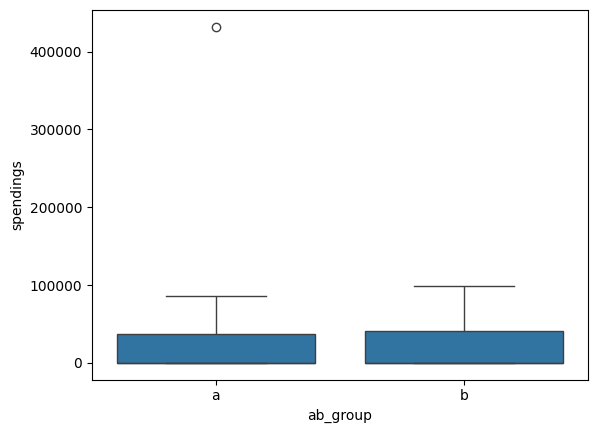

In [18]:
sns.boxplot(x="ab_group", y="spendings", data=df)
# Строим бокс плот. Наблюдаем выброс.

In [19]:
template.merge(financial_group, how='left').groupby('ab_group').sum()['spendings'].reset_index()
# Группируем по группам тестов и смотрим как изменились абсолютные цифры

,ab_group,spendings
0,a,36701565.0
1,b,42415101.0


In [20]:
df= df.sort_values('spendings', ascending=False)
df
# Пользователь 288436107 даёт нам существенный выброс. Он в контрольной группе а и не видит тестируемого блока

,user_id,ab_group,spendings
1880,288436107,a,431883.0
995,24184394,b,99252.0
2260,25304493,a,85280.0
977,24211200,a,84623.0
855,15197585,a,84557.0
...,...,...,...
1783,4998801003,b,0.0
1784,4998839369,b,0.0
1786,4999781169,b,0.0
1787,1998348965,a,0.0


In [21]:
financial[financial['user_id'] == 288436107]
# Смотрим конкретного юзера по которому обнаружены выбросы в финданных. Назовем его "оптовым покупателем"

,user_id,spendings,date
1013,288436107,47987.0,2023-02-10
5479,288436107,47987.0,2023-02-11
6583,288436107,47987.0,2023-02-12
9405,288436107,47987.0,2023-02-13
12204,288436107,47987.0,2023-02-14
17816,288436107,47987.0,2023-02-17
26597,288436107,47987.0,2023-02-20
27234,288436107,47987.0,2023-02-21
33836,288436107,47987.0,2023-02-24


In [22]:
# Убираем юзера с выбросом и убираем всех юзеров у которых нулевые покупки
df1 = df[(df['user_id'] != 288436107) & (df['spendings'] != 0)]
df1

,user_id,ab_group,spendings
995,24184394,b,99252.0
2260,25304493,a,85280.0
977,24211200,a,84623.0
855,15197585,a,84557.0
3522,37317577,b,83712.0
...,...,...,...
3715,24863600,b,13560.0
120,24775296,a,10785.0
3134,15551380,b,10524.0
2332,16314804,b,10290.0


<Axes: xlabel='ab_group', ylabel='spendings'>

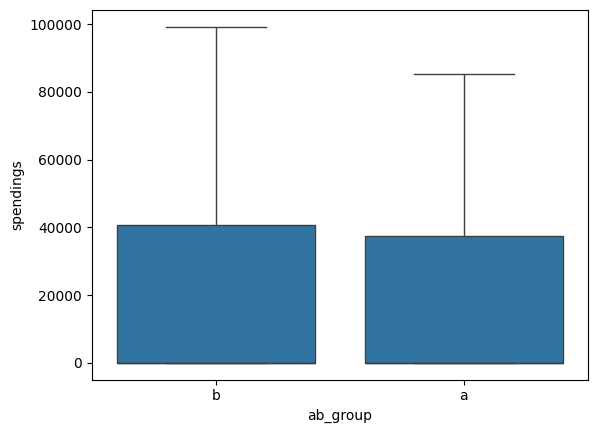

In [23]:
sns.boxplot(x="ab_group", y="spendings", data=df[(df['user_id'] != 288436107)])
# Смотрим данные убрав выброс из за оптового покупателя (юзер - 288436107)

In [24]:
df.describe()

,user_id,spendings
count,4.181000e+03,4181.000000
mean,1.900841e+09,18922.905047
std,2.028184e+09,23388.530292
min,5.214352e+06,0.000000
25%,2.566213e+07,0.000000
50%,1.999113e+09,0.000000
75%,4.998368e+09,39336.000000
max,5.003325e+09,431883.000000


In [25]:
df.pivot_table(index='ab_group', aggfunc={'spendings': 'mean'})

,spendings
ab_group,
a,17636.504085
b,20197.667143


Среднее выше на 14,5%

In [26]:
20197.667143/17636.504085-1

0.14521942929598453

In [31]:
from scipy import stats

In [32]:
stats.ttest_ind(df.query('ab_group=="a"')['spendings'], df.query('ab_group=="b"')['spendings'])

TtestResult(statistic=np.float64(-3.5451942695552376), pvalue=np.float64(0.00039662223018680886), df=np.float64(4179.0))

### pvalue<0.05 Эксперимент статзначимый

In [31]:
df.query('ab_group=="a"')['spendings']

,spendings
1880,431883.0
2260,85280.0
977,84623.0
855,84557.0
582,81290.0
...,...
1776,0.0
1779,0.0
1782,0.0
1787,0.0


<Axes: xlabel='ab_group', ylabel='spendings'>

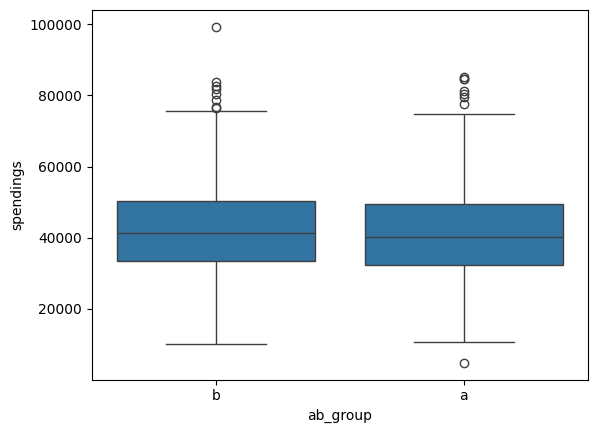

In [28]:
sns.boxplot(x="ab_group", y="spendings", data=df1)
# Смотрим данные убрав выброс из за отпового покупателя (юзер - 288436107) и всех юзеров с нулевыми покупками

In [29]:
# @title Мы рассматриваем временной период в 14 дней
from datetime import datetime

min_dt = financial['date'].min()
min_dt

'2023-02-10'

In [30]:
max_dt = financial['date'].max()
max_dt

'2023-02-24'